# パッケージインストール
※インストール後、セッションを再起動する

In [1]:
!pip install -q av
!pip install -q ffmpeg
!pip install -q qwen_vl_utils
!pip install -q git+https://github.com/huggingface/transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.0/33.0 MB 32.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


# モデルロード

In [1]:
from transformers import Qwen2VLForConditionalGeneration, AutoProcessor

model_path = "Qwen/Qwen2-VL-2B-Instruct"
# model_path = "Qwen/Qwen2-VL-7B-Instruct"

qwen2_vl_model = Qwen2VLForConditionalGeneration.from_pretrained(
    model_path,
    torch_dtype="auto",
    device_map="auto"
)
qwen2_vl_processor = AutoProcessor.from_pretrained(
    model_path
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/56.4k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/3.99G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/429M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/272 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/347 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

In [2]:
import torch
from qwen_vl_utils import process_vision_info

# 推論用関数
def run_inference(processor, model, messages):
    # 入力プロンプトの準備
    text_prompt = processor.apply_chat_template(messages, add_generation_prompt=True)
    image_inputs, video_inputs = process_vision_info(messages)
    inputs = processor(
        text=[text_prompt],
        images=image_inputs,
        videos=video_inputs,
        padding=True,
        return_tensors="pt"
    )
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    inputs = inputs.to(device)

    # 推論
    output_ids = model.generate(**inputs, max_new_tokens=128)
    generated_ids = [
        output_ids[len(input_ids) :]
        for input_ids, output_ids in zip(inputs.input_ids, output_ids)
    ]

    # デコード
    output_text = processor.batch_decode(
        generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True
    )

    return output_text

# 画像推論サンプル

### サンプル画像ダウンロード

In [3]:
!wget https://raw.githubusercontent.com/Kazuhito00/Qwen2-VL-Colaboratory-Sample/main/sample.jpg -q -O test.jpg

(800, 533)


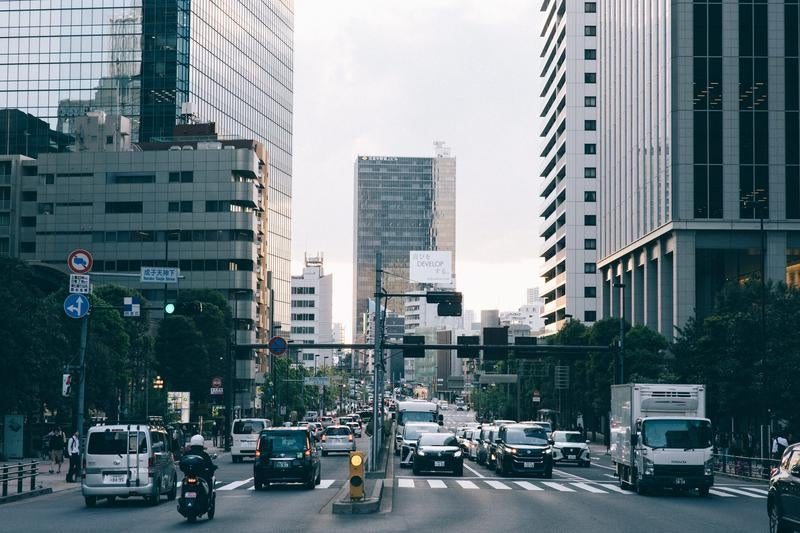

In [4]:
import cv2
from PIL import Image

cv_image = cv2.imread('test.jpg')
rgb_image = cv2.cvtColor(cv_image, cv2.COLOR_BGR2RGB)
pil_image = Image.fromarray(rgb_image)

print(pil_image.size)
pil_image

In [5]:
%%time

# ローカルファイル指定での推論
messages = [
    {
        "role": "user",
        "content": [
            {"type": "image", "image": "test.jpg"},
            {"type": "text", "text": "画像を説明してください"},
        ],
    }
]

output_text = run_inference(qwen2_vl_processor, qwen2_vl_model, messages)
print(output_text)

['この写真は都市の中心部で、多くの高層ビルが立ち並ぶ街角の様子を描いています。道路は幅広く整然と並んでおり、車両が混在しています。人通りも見られます。背景には雲が広がっています。']
CPU times: user 6.33 s, sys: 262 ms, total: 6.59 s
Wall time: 7.98 s


In [6]:
%%time

# PILイメージ指定での推論
messages = [
    {
        "role": "user",
        "content": [
            {"type": "image", "image": pil_image},
            {"type": "text", "text": "画像を説明してください"},
        ],
    }
]

output_text = run_inference(qwen2_vl_processor, qwen2_vl_model, messages)
print(output_text)

['この写真は都市の中心部で、多くの高層ビルが立ち並ぶ街角の様子を描いています。道路は幅広く整然と並んでおり、車両が混在しています。人通りも見られます。背景には雲が広がっています。']
CPU times: user 4.79 s, sys: 111 ms, total: 4.9 s
Wall time: 5.7 s


In [7]:
%%time

# PILイメージ指定での推論(サイズ変更)
messages = [
    {
        "role": "user",
        "content": [
            {"type": "image", "image": pil_image, "resized_width": 300, "resized_height": 200},
            {"type": "text", "text": "画像を説明してください"},
        ],
    }
]

output_text = run_inference(qwen2_vl_processor, qwen2_vl_model, messages)
print(output_text)

['この画像は、都市の中心部にある道路の様子を示しています。道路には多くの車両が並んでおり、その中にはバスやトラックも見られます。道路の両側には高層ビルが建ち並び、天気は曇り空です。全体的に都市の雰囲気が感じられ、ビジネスや生活の繁忙な場所であることが伺えるでしょう。']
CPU times: user 4.4 s, sys: 0 ns, total: 4.4 s
Wall time: 4.44 s


In [8]:
%%time

# URL指定での推論
messages = [
    {
        "role": "user",
        "content": [
            {"type": "image", "image": "https://raw.githubusercontent.com/Kazuhito00/Qwen2-VL-Colaboratory-Sample/main/sample.jpg"},
            {"type": "text", "text": "画像を説明してください"},
        ],
    }
]

output_text = run_inference(qwen2_vl_processor, qwen2_vl_model, messages)
print(output_text)

['この写真は都市の中心部で、多くの高層ビルが立ち並ぶ街角の様子を描いています。道路は幅広く整然と並んでおり、車両が混在しています。人通りも見られます。背景には雲が広がっています。']
CPU times: user 5.17 s, sys: 162 ms, total: 5.33 s
Wall time: 6 s


In [9]:
%%time

import base64

_, imencode_image = cv2.imencode('.jpg', cv_image)
base64_image = base64.b64encode(imencode_image)

# メッセージの準備
messages = [
    {
        "role": "user",
        "content": [
            {"type": "image", "image": "data:image/jpg;base64," + base64_image.decode("ascii")},
            {"type": "text", "text": "画像を説明してください"},
        ],
    }
]

output_text = run_inference(qwen2_vl_processor, qwen2_vl_model, messages)
print(output_text)

['この写真は、都市の中心部にある街並みを描いています。高層ビルが立ち並ぶ都市風景が特徴です。道路には多くの車両が並んでおり、信号灯や標識が設置されています。背景には雲が広がっています。']
CPU times: user 5.37 s, sys: 155 ms, total: 5.53 s
Wall time: 5.54 s


# 動画推論

### サンプル動画ダウンロード

In [10]:
!wget https://raw.githubusercontent.com/Kazuhito00/Qwen2-VL-Colaboratory-Sample/main/sample.mp4 -q -O test.mp4

In [11]:
# 冒頭5秒のみの動画を生成
!ffmpeg -loglevel quiet -i test.mp4 -t 5 -c copy test_5s.mp4

In [12]:
%%time

# ローカルファイル指定での推論
messages = [
    {
        "role": "user",
        "content": [
            {"type": "video", "video": "test_5s.mp4", "fps": 1.0},  # メモリが不足するためFPSを制限、必要に応じて画像と同様に幅、高さも指定可能
            {"type": "text", "text": "動画を説明してください"},
        ],
    }
]

output_text = run_inference(qwen2_vl_processor, qwen2_vl_model, messages)
print(output_text)

['この映像は、Qantas航空のボーイング747がターミナルに到着するシーンを描いています。背景には、日本の国旗とオーストラリアの国旗が掲げられている飛行機の側面が見えます。\n\nその後、映像は紙に描かれたイラストを表示します。イラストには、笑顔のクマが描かれています。クマの上には、日本語の「はじめまして」（こんにちは）と英語の「Hello」が書かれています。\n\nこれらの映像は、Qantas航空のロゴや']
CPU times: user 23.4 s, sys: 1.34 s, total: 24.7 s
Wall time: 27.8 s


In [13]:
import os
import cv2

cap = cv2.VideoCapture("test.mp4")
fps = cap.get(cv2.CAP_PROP_FPS)

# 出力フォルダが存在しない場合は作成
output_directory = "frames"
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

frame_count = 0
second_count = 0
file_list = []
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # 1秒ごとにフレームを保存
    if frame_count % int(fps) == 0:
        filename = f"frame_{second_count:03d}s.jpg"
        output_path = os.path.join(output_directory, filename)
        cv2.imwrite(output_path, frame)
        second_count += 1

        file_list.append(output_path)

    frame_count += 1
cap.release()

In [14]:
print(file_list[:4])

['frames/frame_000s.jpg', 'frames/frame_001s.jpg', 'frames/frame_002s.jpg', 'frames/frame_003s.jpg']


In [15]:
%%time

# 画像ファイルリストでの推論
messages = [
    {
        "role": "user",
        "content": [
            {"type": "video", "video": file_list[:4]},
            {"type": "text", "text": "動画を説明してください"}
        ],
    }
]

output_text = run_inference(qwen2_vl_processor, qwen2_vl_model, messages)
print(output_text)

['この映像では、Qantas航空の飛行機がターミナルに到着するシーンが描かれています。飛行機はターミナルに近づき、エンジンが鳴り始めます。その後、飛行機はターミナルを通過し、画面に描かれたイラストが現れます。イラストには、オーストラリアの国旗と日本語のメッセージが描かれています。']
CPU times: user 23.5 s, sys: 943 ms, total: 24.4 s
Wall time: 24.7 s
